## TODO:

* load poses and point clouds
* get sensor beam angles
* modify get_rays() to use VLP-64 beam angles (not regularly spaced)
* get rays_o/d poses
* verify frame alignment
* copy over training pipeline

# Issue-- This datatset doesn't contain rays associated with non-returns! 
* Not a huge issue as long as we only validate on a other scans.

In [1]:
import numpy as np
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
from scipy.spatial.transform import Rotation as R
import trimesh
from lidar_nerf_utils import *
from matplotlib import pyplot as p
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 8*1024 #22*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

%load_ext autoreload
%autoreload 2
%autosave 180

2024-09-09 22:58:10.105868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 22:58:10.223319: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 22:58:10.621647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-09-09 22:58:10.621727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Virtual devices cannot be modified after being initialized


Autosaving every 180 seconds


In [2]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

idx1 = 1
pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx1:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)
disp.append(Points(pc1, r = 3, c = 'red', alpha = 0.2))

idx2 = 15
pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx2:06}" #+ ".txt"
pc2 = np.loadtxt(pcfn)
pc2 += np.array([idx2-idx1,0,0])
disp.append(Points(pc2, r = 3, c = 'blue', alpha = 0.2))

plt.show(disp, "using data from rosbag not ply files")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

[1. 0. 0. 5. 0. 1. 0. 0. 0. 0. 1. 0.]


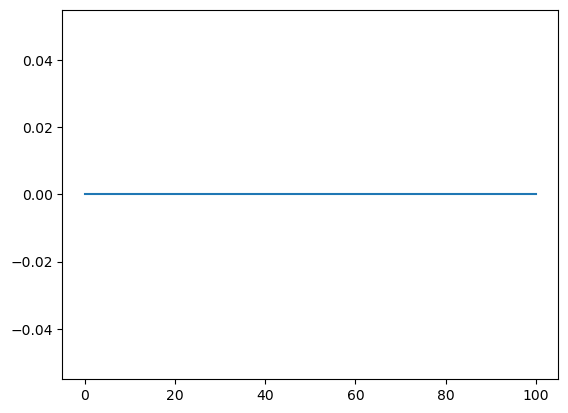

In [3]:
poses = np.loadtxt("/media/derm/06EF-127D4/mai_city/bin/poses/01.txt")
print(poses[5])
trans = np.array([poses[:,3], poses[:,7], poses[:,11]])

fig, ax = p.subplots()
ax.plot(trans[0,:], trans[1,:])

# Issue-- can't use simple look directions on PC as provided

### TODO
* re-distort (can't just align and train right away though!)
* split each scan into 128 horizontal slices
* get pose, rays_o, rays_d for each slice
* get training "images" from each slice
* train rest of the way as normal

In [7]:
n_rots = 128 #128 #number of horizontal subdivisions in sweep 
n_frames = 6
use_every = 5
H = 64
W = 2048//n_rots

images = np.ones([n_frames*n_rots, 64, 2048//n_rots, 2]) #depth and raydrop channels (default all raydrop to 1)
rays_o_all = np.zeros([n_frames*n_rots, 64, 2048//n_rots, 3]) 
rays_d_all = np.zeros([n_frames*n_rots, 64, 2048//n_rots, 3]) 
count = 0

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#go through frames in training data
for idx in range(1,use_every*n_frames,use_every):
#     idx = 0
    pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx:06}" #+ ".txt"
    pc1 = np.loadtxt(pcfn)
#     m_hat = np.array([0.,0.,0.,0.,0.,0.])
    m_hat = np.array([-1.,0.,0.,0.,0.,0.])
    pc1_distorted = apply_motion_profile(pc1, m_hat, period_lidar=1.)
    pc1_distorted += np.array([idx,0,0])
    pc1_distorted = pc1_distorted[:131_072,:] #crop down to 2048 "pixels" in sweep

    #break scan into n_rots azimuthal patches
    for r in range(n_rots):
        pc1_patch = pc1_distorted[r*W*H:(r+1)*W*H,:]
        #TODO: get rays_d directly all at once
        norm = np.sqrt(np.sum(pc1_patch**2, axis = 1))
        rays_d_patch = pc1_patch/norm[:,None]
        rays_d_all[count] = np.reshape(rays_d_patch, [64, -1, 3])
        
        #TODO: hold on to depth image for training
        pc1_spherical = cartesian_to_spherical(pc1_patch)
        pc1_depth_image = np.reshape(pc1_spherical[:,0], [-1,64]).T
        images[count,:,:,0] = pc1_depth_image
        
        #get rays_o
        rays_o = np.array([idx + (r/n_rots), 0., 0.])
        rays_o = np.tile(rays_o, [1,64, 2048//n_rots,1])
        rays_o_all[count] = rays_o
        count += 1
        
        #add back in distortion correction for visualization 
        pc1_patch = pc1_patch + (r/n_rots)*np.array([1,0,0])        
        disp.append(Points(pc1_patch, r = 3, c = np.random.rand(3), alpha = 0.2))

#     disp.append(Points(pc1_distorted, r = 3, c = 'grey', alpha = 0.2))
#     #color by point index
#     pidx = (1/len(pc1_distorted))*np.linspace(0,len(pc1_distorted)-1, len(pc1_distorted))
#     cname = np.array([pidx, 1-pidx, pidx]).T.tolist()
#     disp.append(Points(pc1_distorted, c = cname, r = 3, alpha = 0.1))

images = images.astype(np.float32)
poses = poses.astype(np.float32)
rays_d_all = rays_d_all.astype(np.float32)
rays_o_all = rays_o_all.astype(np.float32)

plt.show(disp, "using data from rosbag not ply files")
ViewInteractiveWidget(plt.window)

/home/derm/ASAR/v3/nerf/lidar_nerf_utils.py:693: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Try training network

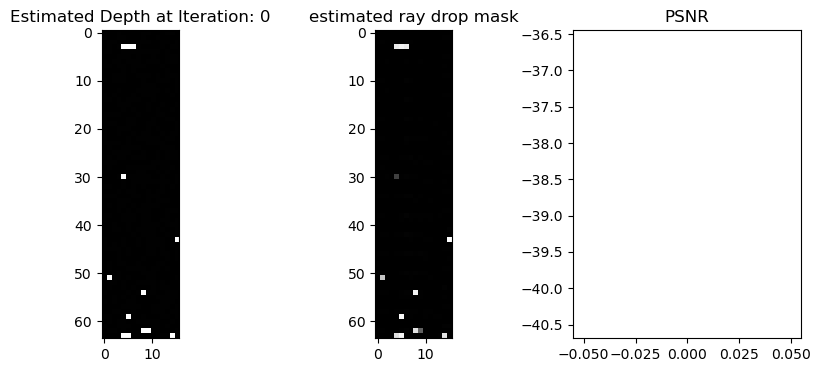

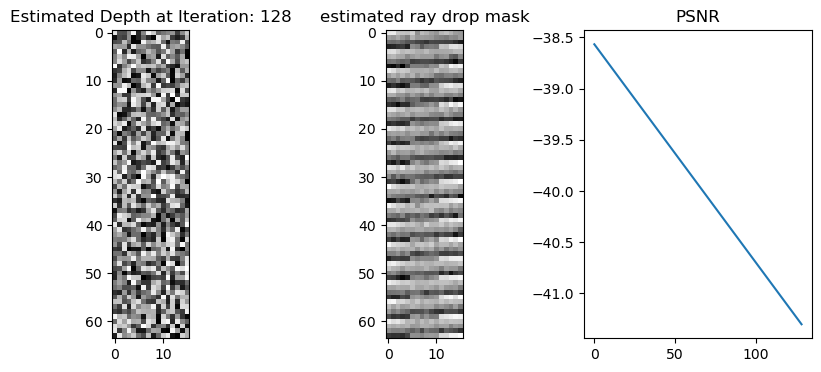

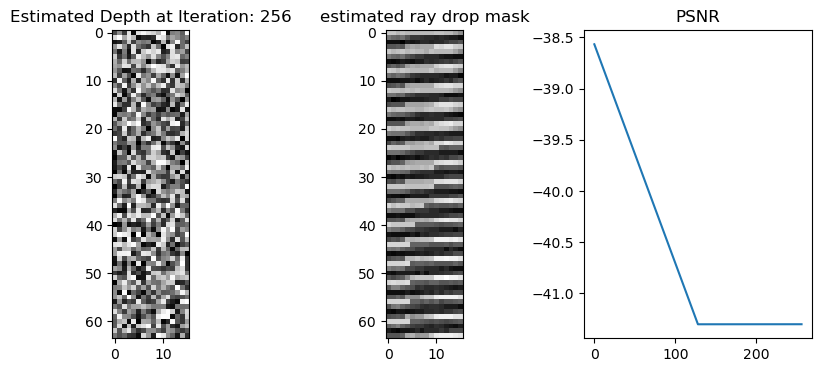

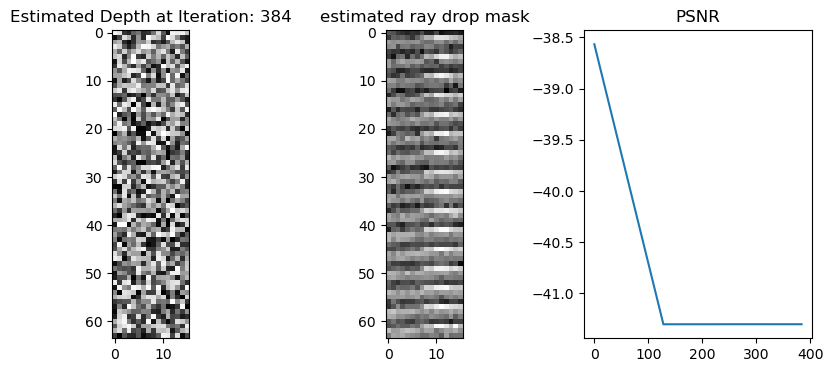

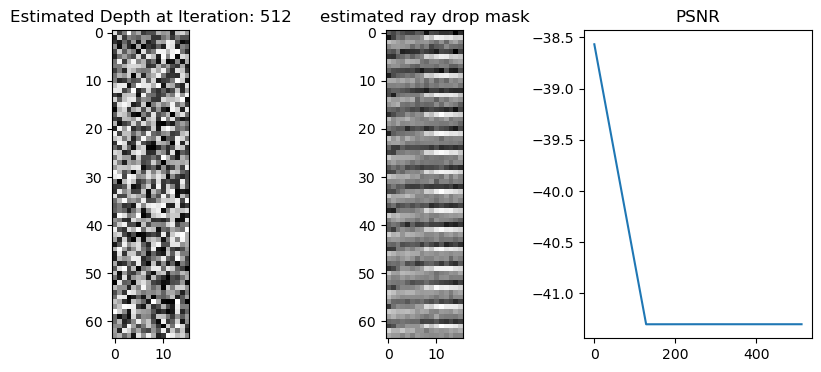

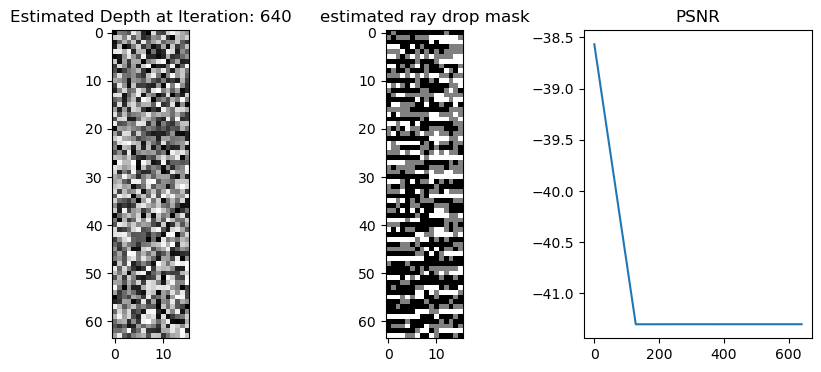


KeyboardInterrupt



In [9]:
from lidar_nerf_utils import *
from numpy.lib.stride_tricks import sliding_window_view

model = init_model()
# model = model_fine # DEBUG - use from coarse to fine 
# optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
optimizer = tf.keras.optimizers.Adam(1e-4)
# optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-5)
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-6) #TEST

N_samples = 128 #128 #256
near=0.
far= 1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 128
accumulate_gradients_steps = 1 #32
# runfine = True
runfine = False

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #1 #number of vertical patches between phimin and phimax (at time of data generation)
H = 64 // n_vert_patches
W = 2048 // n_rots
testimg = images[12]

gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])

    #use full verical patch
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    rays_d = rays_d_all[img_i]
    rays_o = rays_o_all[img_i]
    
#     #break up scans vertically at train time
#     # this works but make sure to drop the LR proportionally!
#     patch_height = 16
#     vert_crop_start = np.random.randint(0,H - patch_height - 1)
#     vert_crop_end = vert_crop_start + patch_height
#     target = images[img_i,vert_crop_start:vert_crop_end,:,:1]
#     target_drop_mask = images[img_i,vert_crop_start:vert_crop_end,:,1:]
#     pose = poses[img_i]
#     rays_d = rays_d_all[img_i, vert_crop_start:vert_crop_end]
#     rays_o = rays_o_all[img_i, vert_crop_start:vert_crop_end]
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
#         z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF) #punish similar depth returns
        loss = loss_coarse

        #not technically correct but helps a to give a warm start
        if runfine:
            # run through a 2nd time network ~~~~~~~~~~~~~~~~~~
            #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
            #TEST-- slightly wider blur-pool
            fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
            rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
            fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
            rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)

    
            #blur-pool as vectorized operation
            test2 = (fwd_test + rev_test) /2 #blur
    #         test2 += 1/N_samples #shift up slightly
            test2 += 1/(3*N_samples) #shift up slightly
            test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
            
            cum_hist_vals = np.cumsum(test2, axis = -1)
            cum_hist_vals_flat = cum_hist_vals.flatten()
    
            #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
            step_corr = np.linspace(0,W*H-1,W*H)
            step_corr = np.tile(step_corr,(N_samples,1)).T
            step_corr = np.reshape(step_corr, [1,-1])[0,:]
            cum_hist_vals_flat+= step_corr
    
            linear_spaced = np.linspace(near, H*W, N_samples*H*W)
#             #fix spacing-- go all the way through [min, max] on every channel???
#             linear_spaced = np.linspace(near, far, N_samples)
#             linear_spaced = np.tile(linear_spaced, (H*W))
#             linear_spaced += step_corr

            ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
            ans -= step_corr
            ans *= far #scale back to max value
#             ans = np.abs(ans) #old-- was shifted to the left
            ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
            z_vals = np.reshape(ans, [H,W,N_samples,1])
            
            gtCDF = z_vals[:,:,:,0] > target[:,:,:]
            gtCDF = tf.cast(gtCDF, tf.float32)
            
#             print(rays_o[0,0,:])
#             print(rays_d[0,0,:])
#             print(z_vals[0,0,:,0])
            rays_o  = tf.cast(rays_o, tf.float32)
            rays_d  = tf.cast(rays_d, tf.float32)
            z_vals  = tf.cast(z_vals, tf.float32)
    
            #run actual 2nd pass through same network
            depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = True)
            depth = depth[:,:,None]
            depth = tf.cast(depth, tf.float32) #why do I have to cast this here???
            ray_drop = ray_drop[:,:,None]
            
            # loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)
            loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
            loss = 0.1*loss_coarse + 0.9*loss_fine 
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
        
        #NEW--prevent NaN gradients from crashing training routine(?) -- needed for monotonically increasing outputs?
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        

#         #OLD-- not working with CDF stuff
#         current_gradients = tape.gradient(loss, model.trainable_variables)
#         gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]    
        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

In [ ]:
#debug getting rays_d from pc1_patch
# print(pc1_patch)
# norm = np.sqrt(np.sum(pc1_patch**2, axis = 1))
# print(norm)
# print(pc1_patch/norm[:,None])
# print("rays_d_all", np.shape(rays_d_all))

# #TODO----- debug getting rays_o
# idx = 5
# rays_o = np.array([idx, 0., 0.])
# print("rays_o: \n", rays_o)
# rays_o = np.tile(rays_o, [1,64, 2048//n_rots,1])
# print(np.shape(rays_o))
# # print(rays_o)

# print(np.shape(pc1_distorted))
pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)
m_hat = np.array([-1.,0.,0.,0.,0.,0.])
pc1_distorted = apply_motion_profile(pc1, m_hat, period_lidar=1.)
pc1_distorted += np.array([idx,0,0])
pc1_distorted = pc1_distorted[:131_072,:] #crop down to 2048 "pixels" in sweep
print(np.shape(pc1_distorted))

r = 0#dummy
pc1_patch = pc1_distorted[r*W*H:(r+1)*W*H,:]
print(np.shape(pc1_patch))
pc1_spherical = cartesian_to_spherical(pc1_patch)

pc1_spherical = pc1_spherical[:,0]
pc1_depth_image = np.reshape(pc1_spherical, [-1,64]).T
print(np.shape(pc1_depth_image))

fig, ax = p.subplots()
ax.imshow(pc1_depth_image)

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]
# disp.append(Points(pc1_patch, r = 3, c = np.random.rand(3), alpha = 0.2))
# plt.show(disp, "using data from rosbag not ply files")
# ViewInteractiveWidget(plt.window)

In [ ]:
# print(np.shape(pc1_spherical))
pc1_spherical = cartesian_to_spherical(pc1_distorted)

#sort by azimuth angle

pc1_spherical = pc1_spherical[:,0]
pc1_depth_image = np.reshape(pc1_spherical, [len(pc1_distorted)//64,-1]).T
# pc1_depth_image = np.flip(pc1_depth_image, axis = 0)
print(np.shape(pc1_depth_image))

fig, ax = p.subplots()
ax.imshow(pc1_depth_image[:,800:1200])

In [ ]:
def interpolate_missing_angles(pc1):
    """pc1 = cartesian coordinates of point cloud AFTER distortion correction has been applied"""

    pc1_spherical = cartesian_to_spherical(pc1).numpy()
    #test moving wrap around to center -- reduce NaNs??
    pc1_spherical[:,1] += np.pi
    pc1_spherical = tf.cast(pc1_spherical, tf.float32)
    
    ray_drops = tf.where(pc1_spherical[:,0]<0.001)
    non_ray_drops = tf.where(pc1_spherical[:,0]>0.001)

    # Generate a regular 2D grid (source grid)
#     source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 63, 64), np.linspace(0, 1023, 1024))
    source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 63, 64), np.linspace(0, len(pc1)//64-1, len(pc1)//64))
    source_points = np.column_stack((source_grid_x.flatten(), source_grid_y.flatten()))
    warped_points = pc1_spherical[:,1:].numpy()
#     print("warped_points", np.shape(warped_points))

    # Select known warped points (subset for interpolation)
    known_indices = non_ray_drops[:,0]
    known_source_points = source_points[known_indices]
    known_warped_points = warped_points[known_indices]

    # Interpolate missing points on the warped grid
    missing_indices = np.setdiff1d(np.arange(len(source_points)), known_indices)  # Remaining points
    missing_source_points = source_points[missing_indices]

    # Use griddata to estimate locations of missing points on the warped grid
    interpolated_points = griddata(known_source_points, known_warped_points, missing_source_points, method='cubic')
#     interpolated_points = np.nan_to_num(interpolated_points, 0)
#     print("\n interpolated_points", np.shape(interpolated_points), interpolated_points)

    #fill interpolated points back in to missing locations
    full_points_spherical = tf.zeros_like(pc1_spherical).numpy()[:,:2]
    #combine via mask old and new interpolated points
    full_points_spherical[non_ray_drops[:,0]] = known_warped_points
    full_points_spherical[ray_drops[:,0]] = interpolated_points

    full_points_spherical = np.append(np.ones([len(full_points_spherical), 1]), full_points_spherical, axis = 1)
    full_points = spherical_to_cartesian(full_points_spherical)
#     print("\n full_points_spherical", np.shape(full_points_spherical), tf.math.reduce_sum(full_points_spherical))

    print(np.shape(interpolated_points))

    p.figure(figsize=(10, 6))
    p.scatter(*zip(*known_warped_points[::10]), color='blue', label='Known Warped Points')
    p.scatter(interpolated_points[:,0], interpolated_points[:,1], color='red', label='Interpolated Points')
    p.legend()
    p.title("Warped Grid with Known and Interpolated Points")
    p.show()

    print(interpolated_points)

    return full_points

idx1 = 30
pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx1:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)
m_hat = np.array([-1.,0,0,0,0,0.])
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
pc1 = pc1[:131_072,:] #crop conservatively so we don't overlap 
full_points = interpolate_missing_angles(pc1)